# Step 1: Data Preprocessing and EDA

In [1]:
# Import libraries
import re
import json
import string
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

## Load dataset

In [2]:
# header for dataset
header = ['Wikipedia article ID', 'Freebase ID', 'Book title', 'Author',
          'Publication date', 'Book genres (Freebase ID:name tuples)',
          'Plot summary']

# Load dataset from text file
data = pd.read_csv('booksummaries.txt', sep='\t', header=None,
                   names=header, encoding='utf-8')

In [3]:
# Display sample of data
data.head()

,Wikipedia article ID,Freebase ID,Book title,Author,Publication date,Book genres (Freebase ID:name tuples),Plot summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [4]:
# Display shape of data
print(f"Shape of dataset: {data.shape}")

Shape of dataset: (16559, 7)


## Preprocess Section

In [5]:
# # Drop "Freebase ID" column cuase that values are unique and useless
data = data.drop("Wikipedia article ID", axis=1)
data = data.drop("Freebase ID", axis=1)

# Add "Index" column by reset it
data = data.reset_index()
data.rename(columns={'index': 'Index'}, inplace=True)

In [6]:
# convert all genres values into tuple
for i in tqdm(range(len(data))):
    try:
        genres_dict = json.loads(data.loc[i, 'Book genres (Freebase ID:name tuples)'])
        if isinstance(genres_dict, dict):
            data.at[i, 'Book genres (Freebase ID:name tuples)'] = tuple(genres_dict.values())
        else:
            data.at[i, 'Book genres (Freebase ID:name tuples)'] = np.nan
    except (TypeError, json.JSONDecodeError):  # Handle NaN values and JSON decoding errors
        continue

data.rename(columns={'Book genres (Freebase ID:name tuples)': 'Book genres'}, inplace=True)

100%|█████████████████████████████████████████████████████████████████████████| 16559/16559 [00:01<00:00, 15254.45it/s]


In [7]:
def extract_year(pub_date):
    """
    Convert publication date to just the year
    (if it's in YYYY-MM-DD format)
    """
    if isinstance(pub_date, str) and '-' in pub_date:
        return pd.to_datetime(pub_date, errors='coerce').year
    return int(pub_date) if isinstance(pub_date, str) and pub_date.isdigit()\
        else np.nan

data['Publication year'] = data['Publication date'].apply(extract_year)

In [8]:
# Remove duplicate rows
# Check for duplicates based on a unique identifier or key columns
duplicates = data.duplicated(subset=['Book title', 'Author'], keep='first')
print(f"Number of duplicate rows: {duplicates.sum()}")

# # Drop duplicates
data = data.drop_duplicates(subset=['Book title', 'Author'], keep='first')

Number of duplicate rows: 8


In [9]:
# text cleaning
# if get an error for this line, you must use `nltk.download()`
# command and download stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Remove extra  before and after whitespace
    text = text.strip()
    return text

data['Cleaned Summary'] = data['Plot summary'].apply(clean_text)

In [10]:
# summary length
data['Summary Length'] = data['Cleaned Summary']\
    .apply(lambda x: len(x.split()))

# Detect outliers in Summary_Length
Q1 = data['Summary Length'].quantile(0.25)
Q3 = data['Summary Length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Summary Length'] < lower_bound) |
                (data['Summary Length'] > upper_bound)]
print(f"Number of outliers in Summary Length: {outliers.shape[0]}")

# Remove outliers
data = data[(data['Summary Length'] >= lower_bound) &
            (data['Summary Length'] <= upper_bound)]

Number of outliers in Summary Length: 953


In [12]:
# Fill Author missing values with 'Unknown' because
# We cannot put anyone's book under the name of another author
data['Author'].fillna('Unknown', inplace=True)

In [13]:
# Fill missing values book generes based of other author's book
# this section of code is not good and fix just 2 rows:)))


def fill_missing_genres(df, num_modes):
    for author, group in tqdm(df.groupby('Author')):
        if author != 'Unknown':
            genres = [genre for genres in group['Book genres'] if
                      isinstance(genres, tuple) for genre in genres]
            if genres:
                mode_genres = [genre for genre, _ in Counter(genres)
                               .most_common(num_modes)]
                # We do this because normaly can't assign tuple
                # and we get an error
                if len(df.loc[(df['Author'] == author) &
                       (df['Book genres'].isnull()), 'Book genres']) > 0:
                    for i in data.loc[(data['Author'] == 'Aaron Allston') &
                                      (data['Book genres'].isnull()),
                                      'Index'].values:
                        df.at[i, 'Book genres'] = tuple(mode_genres)

    return df


# Fill missing genres based on author with the 5 most common genres
data = fill_missing_genres(data, 5)

100%|█████████████████████████████████████████████████████████████████████████████| 4553/4553 [00:13<00:00, 341.27it/s]


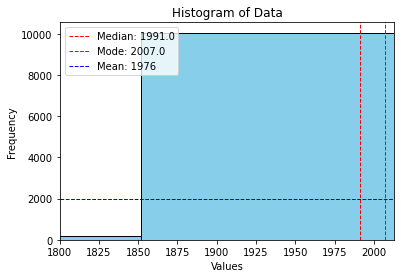

In [14]:
# Plot a histogram to find out median is better for 'Publication year' or mode
median = data['Publication year'].median()
mode = data['Publication year'].mode()[0]
mean = int(data['Publication year'].mean())

plt.hist(data['Publication year'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Add markers for median and mode
plt.axvline(median, color='r', linestyle='dashed',
            linewidth=1, label=f'Median: {median}')
plt.axvline(mode, color='g', linestyle='dashed',
            linewidth=1, label=f'Mode: {mode}')
plt.axhline(mean, color='b', linestyle='dashed',
            linewidth=1, label=f'Mean: {mean}')
plt.xlim(1800, data['Publication year'].max())

plt.legend()
plt.show()

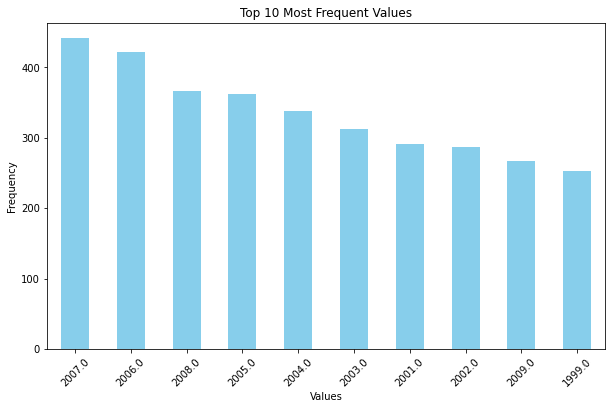

In [15]:
# Calculate the frequency of each value
value_counts = data['Publication year'].value_counts()

# Get the top 10 most frequent values
top_values = value_counts.head(10)

# Plot a bar plot for the top 10 most frequent values
plt.figure(figsize=(10, 6))
top_values.plot(kind='bar', color='skyblue')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Values')
plt.xticks(rotation=45)
plt.show()

In [16]:
# fill Publication Year and Publication date missing value
# with mode of data based on Top 10 values plot
mean_year = int(data['Publication year'].mode()[0])
data['Publication year'].fillna(mean_year, inplace=True)
data['Publication date'].fillna(mean_year, inplace=True)

In [17]:
# We can use "Title-Based" method or Pre-Trained NLP Model
# for Genre Prediction but in this step ignore this method
# and just set this missing value genre with "Unknown" value
data['Book genres'].fillna("Unknown", inplace=True)

In [18]:
# Check the Nan value of all columns
print(data.isna().sum())

Index               0
Book title          0
Author              0
Publication date    0
Book genres         0
Plot summary        0
Publication year    0
Cleaned Summary     0
Summary Length      0
dtype: int64


## EDA section